<a href="https://colab.research.google.com/github/NuelOzeh/Human-Emotion-Detection/blob/main/Human_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IMPORTING NECCESSARY LIBRARIES**#

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive
import glob

In [26]:
# # Enable mixed precision training
# mixed_precision = tf.keras.mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)


#**CONFIGURATION**#

In [3]:
#image_files = glob.glob('/content/dataset/train/*.tif')
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CONFIGURATION = {
    "CLASS_NAMES" : ['angry', 'happy', 'sad'],
    "BATCH_SIZE": 64,
    "IM_SIZE": 256,
    'FILTERS': 6,
    'KERNEL_SIZE':3,
    'STRIDES': 1,
    'POOL_SIZE': 2,
    'DENSE_1': 1024,
    'DENSE_2': 128,
    'NO_CLASSES': 3,
    'LR': 1e-3,
    'DP_RATE': 0.00,
    'EPOCHS': 20,
    'REGULARIZATION_RATE': 0.00

    }

#**DOWNLOADING DATASET**#

In [4]:
pip install kaggle

In [5]:
from google.colab import files

In [6]:
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 305M/309M [00:03<00:00, 92.4MB/s]
100% 309M/309M [00:03<00:00, 99.9MB/s]


In [10]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [27]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [28]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [29]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(64, 256, 256, 3), dtype=float32, numpy=
array([[[[  9.       ,   9.       ,   9.       ],
         [  9.8125   ,   9.8125   ,   9.8125   ],
         [  7.25     ,   7.25     ,   7.25     ],
         ...,
         [ 14.6875   ,  14.6875   ,  14.6875   ],
         [ 14.1875   ,  14.1875   ,  14.1875   ],
         [ 15.       ,  15.       ,  15.       ]],

        [[  7.375    ,   7.375    ,   7.375    ],
         [  8.847656 ,   8.847656 ,   8.847656 ],
         [  6.4375   ,   6.4375   ,   6.4375   ],
         ...,
         [ 13.5703125,  13.5703125,  13.5703125],
         [ 14.1875   ,  14.1875   ,  14.1875   ],
         [ 15.       ,  15.       ,  15.       ]],

        [[  9.0625   ,   9.0625   ,   9.0625   ],
         [ 10.128906 ,  10.128906 ,  10.128906 ],
         [  6.6796875,   6.6796875,   6.6796875],
         ...,
         [ 12.582031 ,  12.582031 ,  12.582031 ],
         [ 15.003906 ,  15.003906 ,  15.003906 ],
         [ 16.375    ,  16.375    ,  16.375 

#**DATA VISUALIZATION**

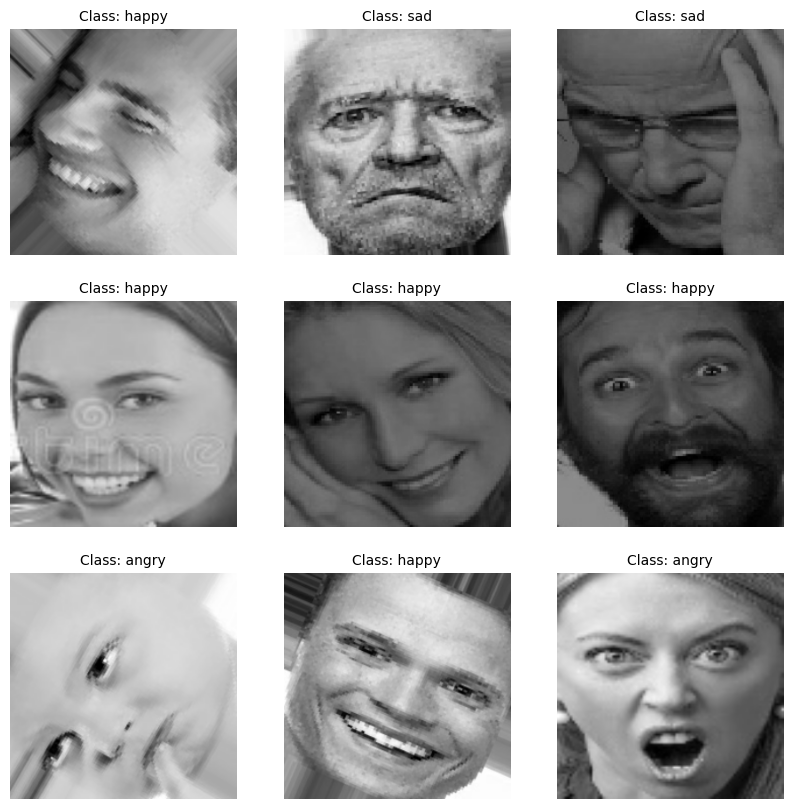

In [30]:
CLASS_NAMES = ['angry', 'happy', 'sad']
# Get one batch from the training dataset
for images, labels in train_dataset.take(1):
    # Set the number of images to display
    num_images = min(9, len(images))

    # Create a subplot with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    # Flatten the axes array
    axes = axes.flatten()

    # Display the images with their corresponding labels
    for i in range(num_images):
        # Display the image
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].axis("off")  # Turn off axis ticks

        # Display the corresponding label
        class_index = tf.argmax(labels[i].numpy())
        class_name = CLASS_NAMES[class_index]
        axes[i].set_title(f"Class: {class_name}", fontsize=10)

    plt.show()


#**DATA PREPROCESSING**#

##**Data Augumentation**

In [31]:
augmentation_layers = tf.keras.Sequential([
    RandomContrast(factor = 0.1),
    RandomFlip(mode = 'horizontal',),
    RandomRotation(factor = (-0.020, 0.020),)
]
)

In [32]:
def augmentation_layer(image, label):
    return augmentation_layers(image, training = True), label

##**Prefetching**

In [33]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
    .map(augmentation_layer, num_parallel_calls = tf.data.AUTOTUNE)
)

In [34]:
validation_dataset = (
    val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

##**Resizing and Rescaling**##

In [35]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(height=256, width=256),
    Rescaling(scale=1./255),
])

#**MODEL**#

##**lenet**



In [41]:
lenet_model = tf.keras.Sequential(
    [
                            InputLayer(input_shape = (None, None, 3),),

                            resize_rescale_layers,

                            Conv2D(filters = CONFIGURATION['FILTERS'],
                                   kernel_size = CONFIGURATION['KERNEL_SIZE'],
                                   strides = CONFIGURATION['STRIDES'],
                                   padding = 'valid', activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),

                            BatchNormalization(),
                            MaxPooling2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['STRIDES']+1),

                            Dropout(rate = CONFIGURATION['DP_RATE']),

                            Conv2D(filters = CONFIGURATION['FILTERS'] ** 2 / 2,
                                   kernel_size = CONFIGURATION['POOL_SIZE'],
                                   strides = CONFIGURATION['STRIDES'],
                                   padding = 'valid', activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),

                            BatchNormalization(),
                            MaxPooling2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['STRIDES']),

                            Dropout(rate = CONFIGURATION['DP_RATE']),

                            Flatten(),

                            Dense(CONFIGURATION['DENSE_1'], activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
                            BatchNormalization(),

                            Dense(CONFIGURATION['DENSE_2'], activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
                            BatchNormalization(),

                            Dense(CONFIGURATION['NO_CLASSES'], activation = 'softmax'),
])

lenet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 126, 18)     

##**Training**##

In [43]:
loss_func = CategoricalCrossentropy()

In [44]:
metrics = [CategoricalAccuracy(name = 'Accuracy'), TopKCategoricalAccuracy(k = 2, name= 'Topk_accuracy')]

In [45]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LR']),
    loss = loss_func,
    metrics = metrics
)

In [46]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['EPOCHS'],
    verbose=1,
)

InvalidArgumentError: ignored

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['Accuracy'], label='Training accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation accuracy')
plt.title('Training and Validation_accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation')
plt.legend()
plt.show()

In [ ]:
lenet_model.evaluate(validation_dataset)

##*Testing*##

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/116802.jpg")

result = tf.constant(test_image, dtype = tf.float32)
result = tf.expand_dims(test_image, axis = 0)

print(CLASS_NAMES[tf.argmax(lenet_model(result), axis = -1).numpy()[0]])

##*Confusion Marix*##

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


predictions = lenet_model.predict(val_dataset)

# Convert predicted probabilities to class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Get true labels from the generator
true_labels = val_dataset.classes

# Compute confusion matrix using scikit-learn
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.class_indices, yticklabels=val_dataset.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=val_dataset.class_indices.keys()))